In [1]:
# Import librairies
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LinearRegression
from collections import Counter
from imblearn.over_sampling import SMOTE

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

# Model Selection and metrics
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import roc_curve
from statistics import mean
from sklearn.metrics import accuracy_score
import shap  

In [2]:
# Remove useless warnings
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [3]:
# Import data
df = pd.read_csv("diabetes.csv")

In [4]:
# Observe the dataset
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
# Provide information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [6]:
# Find the number of missing values
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

There appear to be no missing values and the column types seem well defined.

# Data Analysis

## Analysis of the outcome

In [7]:
# The variable we want to predict is the outcome.
prediction = 'Outcome'

# We define 2 dataframes with those for which the variable we want to predict is positive or negative
df_positive = df[df[prediction] == 1]
df_negative = df[df[prediction] == 0]

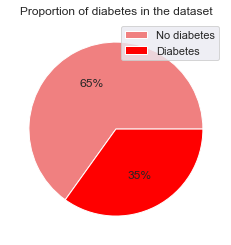

In [8]:
# We look at the distribution of the prediction variable
sns.set(font_scale=1)
plt.pie(df[prediction].value_counts(normalize=True), labels=['No diabetes', 'Diabetes'], autopct='%1.0f%%', 
        colors=['lightcoral', 'red'], labeldistance=None)
plt.title("Proportion of diabetes in the dataset")
plt.legend() 
plt.savefig('proportion_diabetes.png')
plt.show()

The dataset provided includes almost two thirds of people who have not had diabetes compared to one third of those who have had it. It is therefore a little **unbalanced dataset**, which should be taken into account in the following.

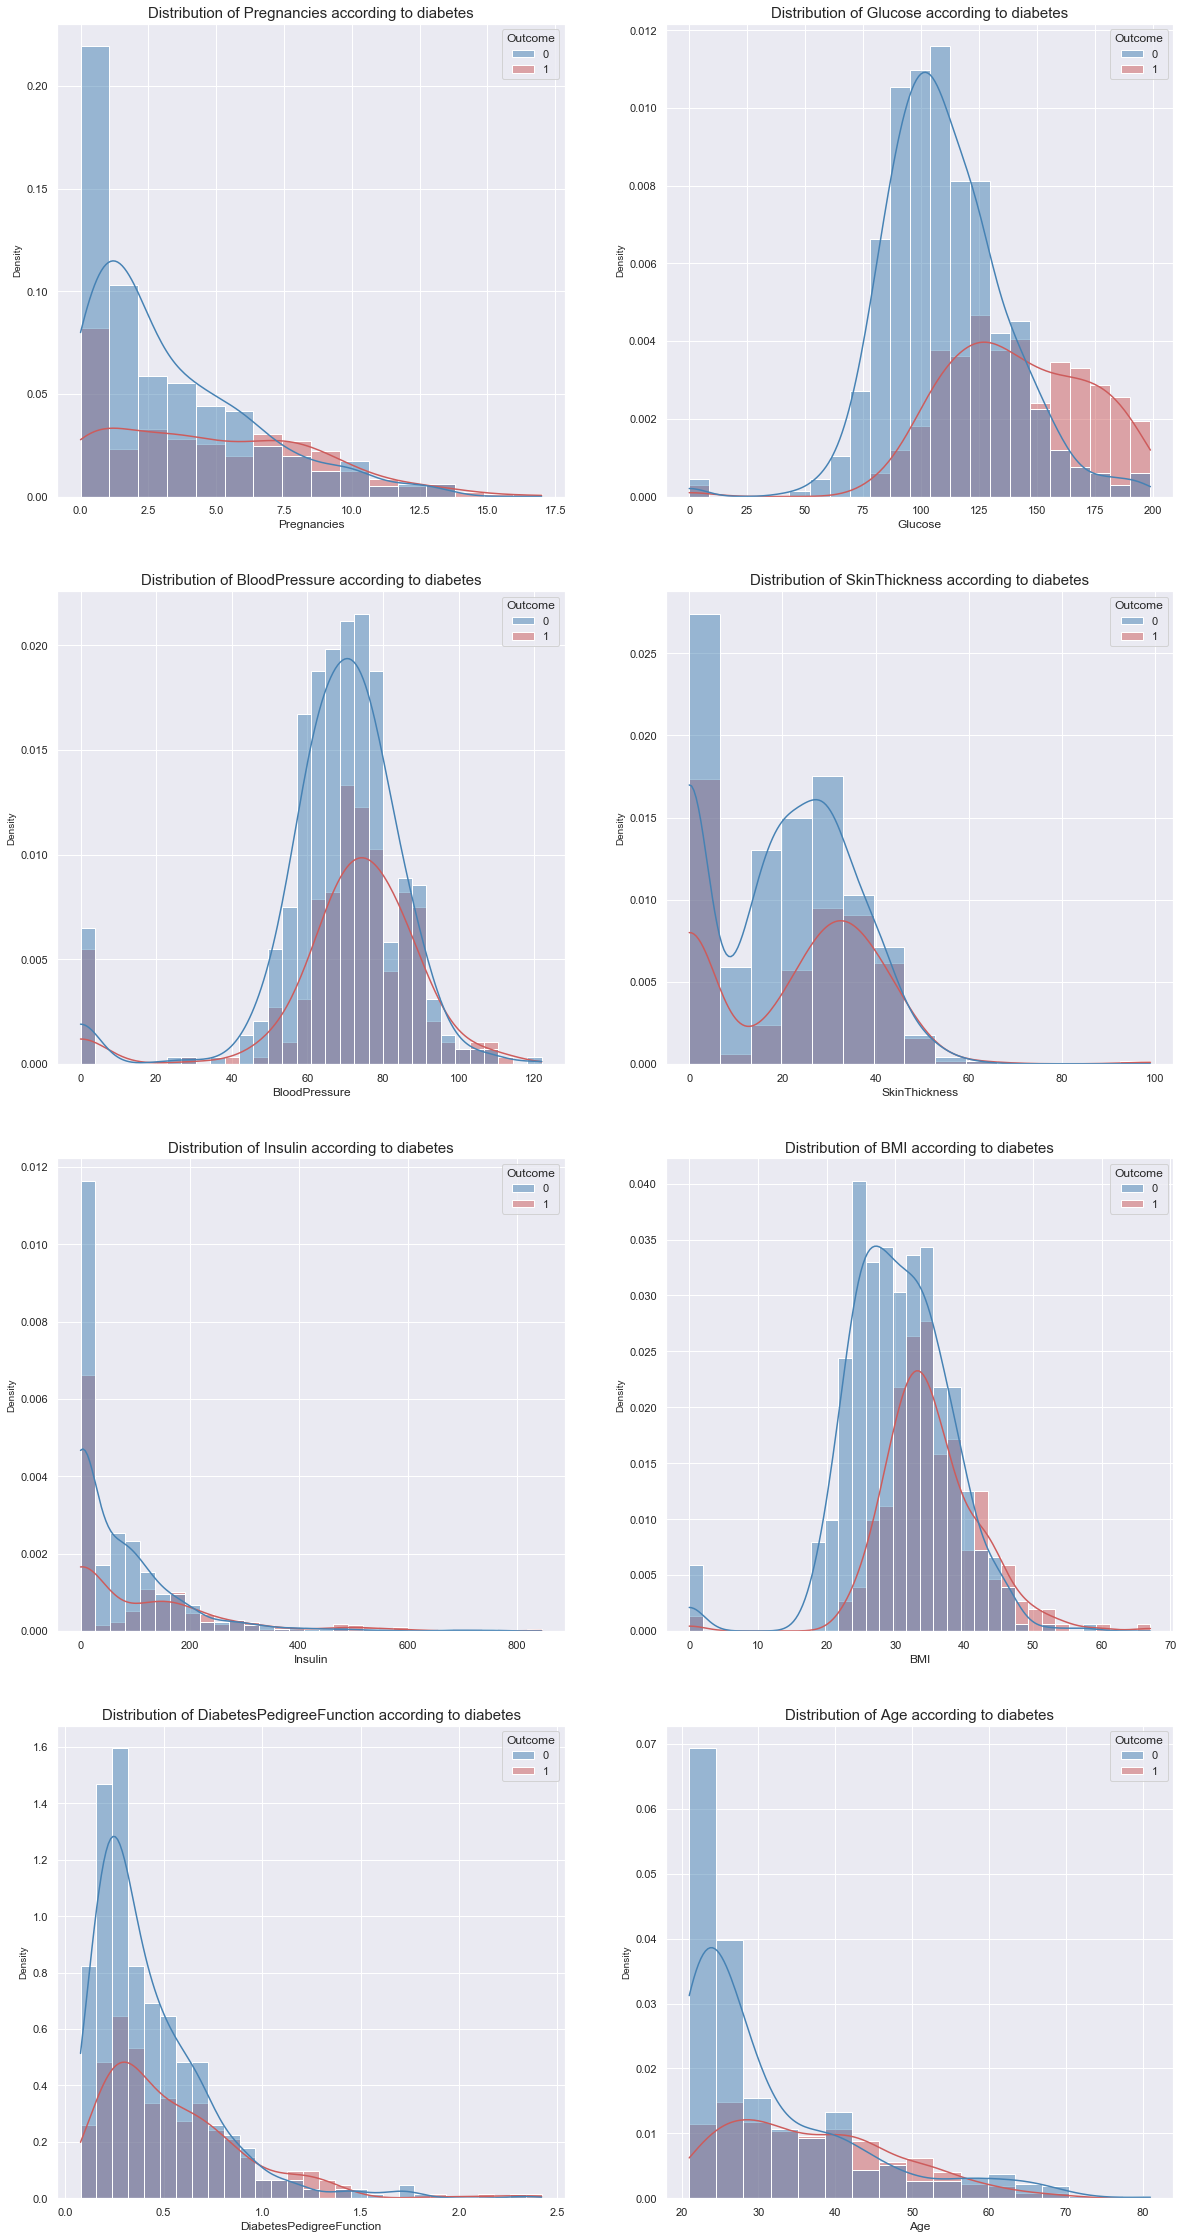

In [9]:
# Distribution of continuous variables as a function of the outcome
i = 1
liste = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age']
for col in liste:
    plt.figure(1, figsize=(20, 40))
    plt.subplot(4, 2, i)
    sns.histplot(data=df, x=col, hue='Outcome', kde=True, stat='density', palette=['steelblue', 'indianred'], 
                 legend=True)
    plt.ylabel('Density', fontsize=10)
    plt.title('Distribution of ' + col + " according to diabetes", fontsize=15)
    i+=1

In these graphs we can see a big difference between the distribution of people with and without diabetes for **glucose**. We can therefore assume that this variable will be of **great importance for the prediction** of the outcome. Moreover, there is also a slight difference in **age** and **diabetes pedigree function**.

On the other hand, we also notice a large number of zeros for some variables: Insulin, skin thickness, blood pressure. As this value is normally not a possible value, we can deduce that in this data set **the missing values have been replaced by zeros**.

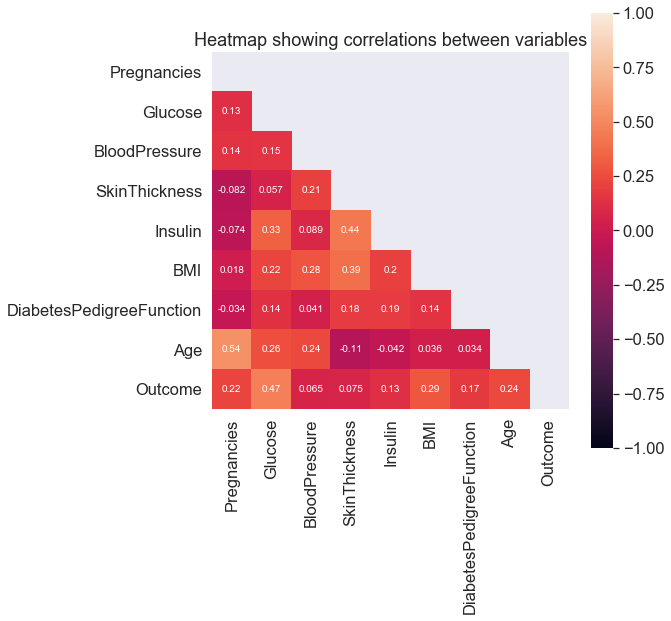

In [10]:
# Creation of a heatmap to see the correlations between the variables
plt.figure(figsize=(8,8))
sns.set(font_scale=1.5)
mask = np.zeros_like(df.corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df.corr(), annot=True, annot_kws={'size': 10}, mask=mask, square=True, vmin=-1, vmax=1)
plt.title("Heatmap showing correlations between variables")
plt.savefig("heatmap.png")
plt.show()

In [11]:
# Correlation with the outcome
df_corr = df[df.columns].corr().abs()['Outcome'][:-1]
sort = df_corr.sort_values(ascending=False)
sort.head(10)

Glucose                     0.466581
BMI                         0.292695
Age                         0.238356
Pregnancies                 0.221898
DiabetesPedigreeFunction    0.173844
Insulin                     0.130548
SkinThickness               0.074752
BloodPressure               0.065068
Name: Outcome, dtype: float64

As supposed before, we have a great correlation between **glucose and diabetes**, but also BMI, age and pregnancies. Moreover the heatmap shows up that some variables appear to be correlated together like **age and pregnancies**, but also **insulin and skin thickness**.

# Model Training
## Preprocessing Data
### Missing values

In [12]:
df_1 = df.copy()

In [13]:
# Replacing values 0 by nan values
df['SkinThickness'] = df['SkinThickness'].replace(0, np.nan)
df['BloodPressure'] = df['BloodPressure'].replace(0, np.nan)
df['Insulin'] = df['Insulin'].replace(0, np.nan)
df['BMI'] = df['BMI'].replace(0, np.nan)
df['Glucose'] = df['Glucose'].replace(0, np.nan)

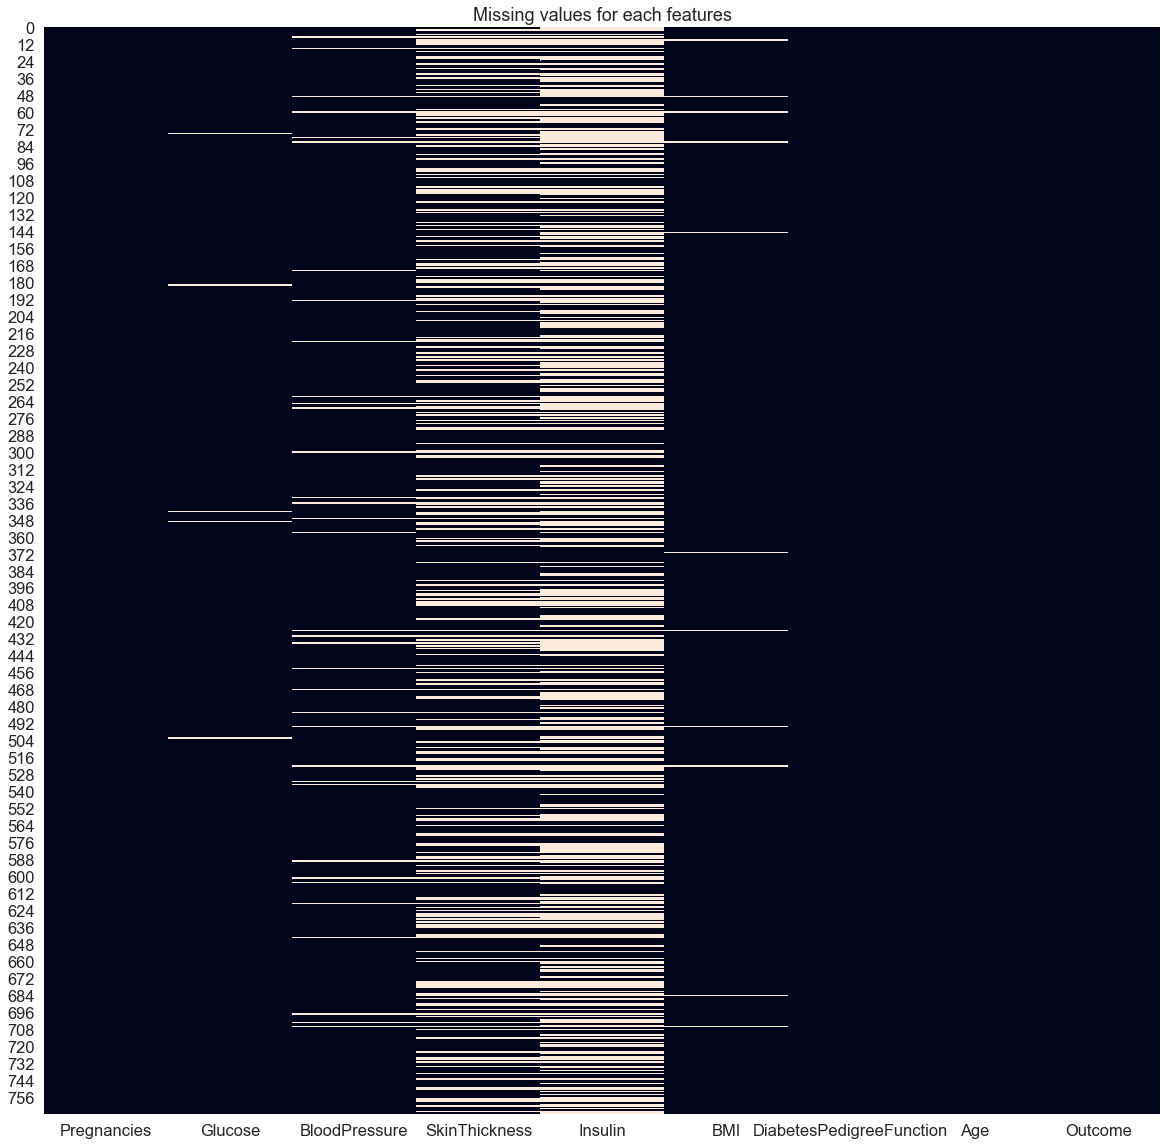

In [14]:
# Ploting the missing values throughout the dataset
plt.figure(figsize=(20,20))
plt.title("Missing values for each features")
sns.heatmap(df.isna(), cbar=False)
plt.show()

In [15]:
# Proportion of missing values for each feature
df.isnull().sum()/len(df)

Pregnancies                 0.000000
Glucose                     0.006510
BloodPressure               0.045573
SkinThickness               0.295573
Insulin                     0.486979
BMI                         0.014323
DiabetesPedigreeFunction    0.000000
Age                         0.000000
Outcome                     0.000000
dtype: float64

It can be noted that Skin Thickness and Insulin have many missing values whereas glucose, blood pressure and BMI have few ones. Therefore we are not going to manage these in the same way. Indeed, for glucose, blood pressure and BMI, we are going to take the mean. However, when there is a too large proportion of missing values, using the mean is meaningless. That's why we are going to predict the value thanks to the others for skin thickness and insulin.

In [16]:
# Replace missing values by the mean for glucose, blood pressure and BMI
df['Glucose'] = df['Glucose'].fillna(df['Glucose'].mean())
df['BloodPressure'] = df['BloodPressure'].fillna(df['BloodPressure'].mean())
df['BMI'] = df['BMI'].fillna(df['BMI'].mean())

In [17]:
# Predict the skin thickness missing values thanks to the other one with linear regression
# set up the linear regression model
lr = LinearRegression()

# Split the dataset in the train set (with skin thickness values) and the test set (missing values)
test_set = df[df['SkinThickness'].isnull()==True]
train_set = df[df['SkinThickness'].isnull()==False]

# Keep the insulin data in mind 
insulin_train_set = train_set['Insulin']
insulin_test_set = test_set['Insulin']

# Keep the outcome data in mind 
outcome_train_set = train_set['Outcome']
outcome_test_set = test_set['Outcome']

# Take the feature we want to predict
y = train_set['SkinThickness']

## Remove data from the train and test set
# Skin thickness because is the feature we want to predict 
# Outcome because if we predict skin thickness taking into account the outcome, this will distort the final result of predicting the outcome from the features alone
# Insulin because there are too much missing values
train_set.drop(["SkinThickness", "Outcome", "Insulin"],axis=1,inplace=True)
test_set.drop(["SkinThickness", "Outcome", "Insulin"],axis=1,inplace=True)

# Fit the model
lr.fit(train_set,y)

# Predict the missing values
pred = lr.predict(test_set)

## Replace the removing data 
# Skinthickness
test_set['SkinThickness']= pred
train_set['SkinThickness'] = y
# Insulin
train_set['Insulin'] = insulin_train_set
test_set['Insulin'] = insulin_test_set
# Outcome
train_set['Outcome'] = outcome_train_set
test_set['Outcome'] = outcome_test_set

# Concatenate to create the data set again
df = pd.concat([train_set, test_set], axis=0)

In [18]:
# Predict the insulin missing values thanks to the other one with linear regression
# set up the linear regression model
lr = LinearRegression()

# Split the dataset in the train set (with insulin values) and the test set (missing values)
test_set = df[df['Insulin'].isnull()==True]
train_set = df[df['Insulin'].isnull()==False]

# Keep the outcome data in mind 
outcome_train_set = train_set['Outcome']
outcome_test_set = test_set['Outcome']

# Take the feature we want to predict
y = train_set['Insulin']

## Remove data from the train and test set
# Insulin because is the feature we want to predict 
# Outcome because if we predict insulin taking into account the outcome, this will distort the final result of predicting the outcome from the features alone
train_set.drop(["Outcome", "Insulin"],axis=1,inplace=True)
test_set.drop(["Outcome", "Insulin"],axis=1,inplace=True)

# Fit the model
lr.fit(train_set,y)

# Predict the missing values
pred = lr.predict(test_set)

## Replace the removing data 
# Insulin
test_set['Insulin']= pred
train_set['Insulin'] = y
# Outcome
train_set['Outcome'] = outcome_train_set
test_set['Outcome'] = outcome_test_set

# Concatenate to create the data set again
df = pd.concat([train_set, test_set], axis=0)

In [19]:
# Looking at the data set now
df.head()

,Pregnancies,Glucose,BloodPressure,BMI,DiabetesPedigreeFunction,Age,SkinThickness,Insulin,Outcome
3,1,89.0,66.0,28.1,0.167,21,23.0,94.0,0
4,0,137.0,40.0,43.1,2.288,33,35.0,168.0,1
6,3,78.0,50.0,31.0,0.248,26,32.0,88.0,1
8,2,197.0,70.0,30.5,0.158,53,45.0,543.0,1
13,1,189.0,60.0,30.1,0.398,59,23.0,846.0,1


In [186]:
# Split the data set into the features data set and the outcome one
X = df.drop(['Outcome'], axis=1)
y = df['Outcome']

In [187]:
# Split into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.33,
                                                    random_state=0)

In [188]:
counter = Counter(y_train)
print(counter)

Counter({0: 334, 1: 180})


We have 334 individuals without diabetes against 180 with diabetes in the train set, which make our dataset unbalanced.

In [189]:
# Oversample the trainset to compensate for the unbalanced data set
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

In [190]:
counter = Counter(y_train)
print(counter)

Counter({0: 334, 1: 334})


After over sampling, we now have the same amount of people for each category.

### Scaler Selection

In [191]:
# Chose possibles scalers
standard_scaler = StandardScaler()
robust_scaler = RobustScaler()
minmax_scaler = MinMaxScaler()

In [192]:
# Scale data regarding the scaler used
X_train_st = standard_scaler.fit_transform(X_train)
X_test_st = standard_scaler.transform(X_test)

X_train_rob = robust_scaler.fit_transform(X_train)
X_test_rob = robust_scaler.transform(X_test)

X_train_mm = minmax_scaler.fit_transform(X_train)
X_test_mm = minmax_scaler.transform(X_test)

In [193]:
# Create a function to find the best scaler
def find_best_scaler(model_name):
    '''
    Find the best scaler regarding the model used with the accuracy score obtained
    Input: model_name, sklearn model
    '''
    better_score = 0
    better_scaler = ''

    X_train_list = [X_train_st, X_train_rob, X_train_mm]
    X_test_list = [X_test_st, X_test_rob, X_test_mm]
    scalers = ["Standard", "Robust", "MinMax"]
    
    for i in range(len(X_test_list)):
        model = model_name
        model.fit(X_train_list[i], y_train)
        score = accuracy_score(y_test, model.predict(X_test_list[i]))
        if score > better_score:
            better_score = score
            better_scaler = scalers[i]
        elif score == better_score:
            better_scaler += " / " + scalers[i]
    print("For {}, better score {} with {}.".format(model_name, better_score, better_scaler))

In [194]:
find_best_scaler(RandomForestClassifier())

For RandomForestClassifier(), better score 0.7440944881889764 with Standard / Robust.


In [197]:
find_best_scaler(DecisionTreeClassifier())

For DecisionTreeClassifier(), better score 0.7047244094488189 with Standard.


In [198]:
find_best_scaler(LogisticRegression())

For LogisticRegression(), better score 0.7716535433070866 with Standard / Robust.


In [200]:
find_best_scaler(KNeighborsClassifier())

For KNeighborsClassifier(), better score 0.7519685039370079 with Standard.


In [205]:
find_best_scaler(SVC())

For SVC(), better score 0.7755905511811023 with MinMax.


Robust seems to be the scaler having better scores on average.

In [206]:
X_train = X_train_st.copy()
X_test = X_test_st.copy()

In [207]:
X_train_df = pd.DataFrame(X_train, columns=X.columns)

## Train models

### Tuning of the Hyper-parameters

In [208]:
# Definition of hyperparameter dictionaries
dico_param_tree = {'decisiontreeclassifier__criterion': ['gini', 'entropy'],
         'decisiontreeclassifier__splitter': ['best', 'random']}
dico_param_rf = {"randomforestclassifier__n_estimators": np.arange(10, 100, 20),
              "randomforestclassifier__criterion": ['gini', 'entropy'],
              "randomforestclassifier__max_features": ['auto', 'sqrt', 'log2'],
              "randomforestclassifier__class_weight": [None, 'balanced']}
dico_param_log = {'logisticregression__solver': ['newton-cg', 'lbfgs', 
                                                 'liblinear', 'sag', 'saga']}
dico_param_knn = {"kneighborsclassifier__n_neighbors":np.arange(2, 10, 1),
                 "kneighborsclassifier__weights": ['uniform', "distance"],
                 "kneighborsclassifier__algorithm": ["auto", "ball_tree", "kd_tree", "brute"]}
dico_param_svm = {'svc__kernel':["linear", "poly", "rbf", "sigmoid"], 
           "svc__gamma":['scale', "auto"],
                 "svc__probability":[True, False]}

model_rf = make_pipeline(RandomForestClassifier())
model_tree = make_pipeline(DecisionTreeClassifier())
model_log = make_pipeline(LogisticRegression())
model_knn = make_pipeline(KNeighborsClassifier())
model_svm = make_pipeline(SVC())

In [209]:
# Search for the best hyperparameters for each model
SCORING = 'f1_weighted' # we want 'recall' and 'precision' to matter

# Definition of a function giving the best parameters
def best_param(X, y, pipeline, dico_param):
    # Create a grid search to obtain the best hyperparameters
    grid = GridSearchCV(
        pipeline, 
        param_grid=dico_param,  
        cv=5, # crossvalidation of 5
        refit=True, # at the end, it selects the best set of hyperparameters and retrain the model on all data
        scoring=SCORING)
    
    # fit the grid search
    grid.fit(X, y)
    print(f"Best estimator has {SCORING}={round(grid.best_score_, 2)}")
    
    # Keep the best model in mind
    best_model = grid.best_estimator_
    print("Le meilleur modèle est :", best_model[0])
    return best_model[0]

In [210]:
# Finding the best parameters for Logistic Regression
best_model_log = best_param(X_train, y_train, model_log, dico_param_log)

Best estimator has f1_weighted=0.75
Le meilleur modèle est : LogisticRegression(solver='newton-cg')


In [211]:
# Finding the best parameters for Decision Tree
best_model_tree = best_param(X_train, y_train, model_tree, dico_param_tree)

Best estimator has f1_weighted=0.77
Le meilleur modèle est : DecisionTreeClassifier()


In [212]:
# Finding the best parameters for Knn
best_model_knn = best_param(X_train, y_train, model_knn, dico_param_knn)

Best estimator has f1_weighted=0.8
Le meilleur modèle est : KNeighborsClassifier(n_neighbors=6, weights='distance')


In [213]:
# Finding the best parameters for SVM
best_model_svm = best_param(X_train, y_train, model_svm, dico_param_svm)

Best estimator has f1_weighted=0.78
Le meilleur modèle est : SVC(kernel='poly', probability=True)


In [214]:
# Finding the best parameters for RandomForest
best_model_rf = best_param(X_train, y_train, model_rf, dico_param_rf)

Best estimator has f1_weighted=0.83
Le meilleur modèle est : RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       n_estimators=90)


## Training the best models

In [215]:
# Creation of a function to train the model and obtain diverse results
def fit(X_train, X_test, y_train, model):
    
    accuracy = mean(cross_val_score(model, X_train, y_train, cv=StratifiedKFold(), scoring='accuracy'))
    auc = mean(cross_val_score(model, X_train, y_train, cv=StratifiedKFold(), scoring='roc_auc'))
    precision = mean(cross_val_score(model, X_train, y_train, cv=StratifiedKFold(), scoring='precision'))
    recall = mean(cross_val_score(model, X_train, y_train, cv=StratifiedKFold(), scoring='recall'))
    f1_weighted = mean(cross_val_score(model, X_train, y_train, cv=StratifiedKFold(), scoring='f1_weighted'))
    proba = model.predict_proba(X_test)[:,1]
    
    print("**** Results for the {} model ****".format(model))
    print('Accuracy: {:.3g}'.format(accuracy))
    print('Precision: {:.3g}'.format(precision))
    print('Recall: {:.3g}'.format(recall))
    print('F1 weighted: {:.3g}'.format(f1_weighted))
    print('AUC score: {:.3g}'.format(auc))
    
    return accuracy, auc, precision, f1_weighted, proba, recall

In [216]:
# Creation of a function that returns the best features with respect to variance
def best_features(model, X_train_df, threshold) :     
    features_importances = []
    index_best_features = []
    list_results = model.feature_importances_.tolist()
    best_features = []
    for i in range(len(list_results)):
        if list_results[i] > threshold :
            index_best_features.append(i)
            features_importances.append(list_results[i])
            best_features.append(X_train_df.columns[i])
    return best_features, features_importances

**** Results for the RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       n_estimators=90) model ****
Accuracy: 0.816
Precision: 0.801
Recall: 0.869
F1 weighted: 0.82
AUC score: 0.905


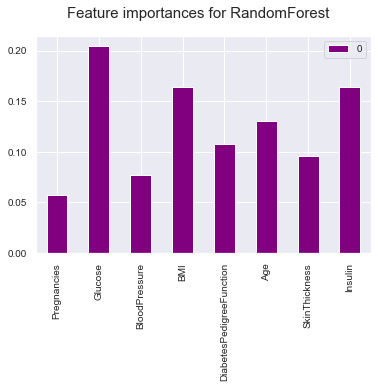

In [217]:
# Random Forest Classifier
accuracy_rf, auc_rf, precision_rf, f1_weighted_rf, proba_rf, recall_rf = fit(X_train, X_test, y_train, best_model_rf)

best_features_rf, features_importance_rf = best_features(best_model_rf, X_train_df, 0.02)

pd.DataFrame(features_importance_rf, index = best_features_rf).plot.bar(color='purple')
plt.suptitle('Feature importances for RandomForest', fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=10)
plt.show()

**** Results for the DecisionTreeClassifier() model ****
Accuracy: 0.765
Precision: 0.735
Recall: 0.779
F1 weighted: 0.766
AUC score: 0.765


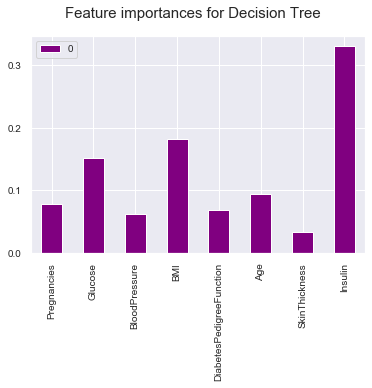

In [218]:
# Decision Tree
accuracy_tree, auc_tree, precision_tree, f1_weighted_tree, proba_tree, recall_tree = fit(X_train, X_test, y_train, best_model_tree)

best_features_tree, features_importance_tree = best_features(best_model_tree, X_train_df, 0.02)

pd.DataFrame(features_importance_tree, index = best_features_tree).plot.bar(color='purple')
plt.suptitle('Feature importances for Decision Tree', fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=10)
plt.show()

In [219]:
# Logistic Regression
accuracy_log, auc_log, precision_log, f1_weighted_log, proba_log, recall_log = fit(X_train, X_test, y_train, best_model_log)

**** Results for the LogisticRegression(solver='newton-cg') model ****
Accuracy: 0.755
Precision: 0.771
Recall: 0.725
F1 weighted: 0.754
AUC score: 0.84


In [220]:
# KNN
accuracy_knn, auc_knn, precision_knn, f1_weighted_knn, proba_knn, recall_knn = fit(X_train, X_test, y_train, best_model_knn)

**** Results for the KNeighborsClassifier(n_neighbors=6, weights='distance') model ****
Accuracy: 0.802
Precision: 0.751
Recall: 0.904
F1 weighted: 0.8
AUC score: 0.879


In [221]:
# SVM
accuracy_svm, auc_svm, precision_svm, f1_weighted_svm, proba_svm, recall_svm = fit(X_train, X_test, y_train, best_model_svm)

**** Results for the SVC(kernel='poly', probability=True) model ****
Accuracy: 0.782
Precision: 0.753
Recall: 0.838
F1 weighted: 0.781
AUC score: 0.844


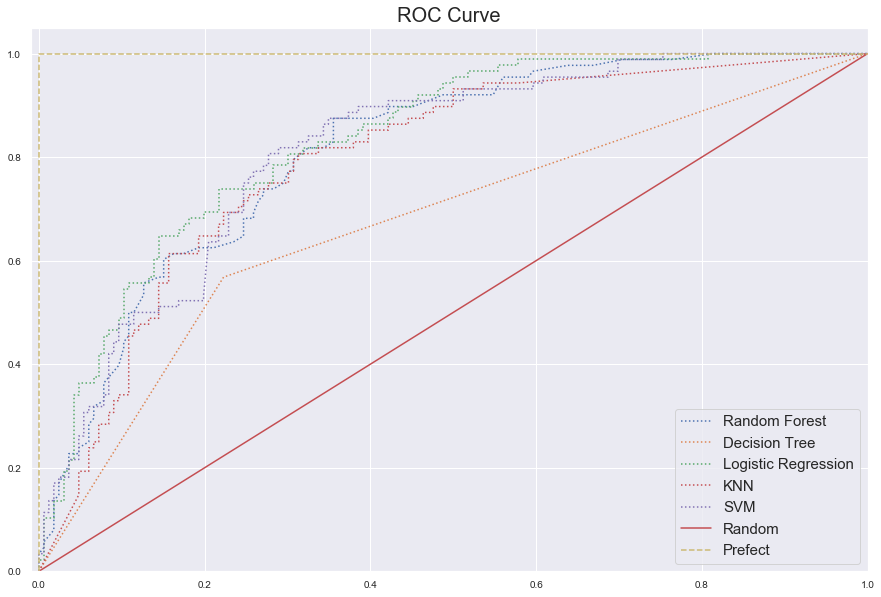

In [222]:
# ROC curve
plt.figure(1, figsize=(15, 10))
# Random Forest
fpr, tpr, _ = roc_curve(y_test, proba_rf)
plt.plot(fpr,tpr,":", label="Random Forest")

# Decision Tree
fpr, tpr, _ = roc_curve(y_test, proba_tree)
plt.plot(fpr,tpr,":", label="Decision Tree")

# Logistic Regression
fpr, tpr, _ = roc_curve(y_test, proba_log)
plt.plot(fpr,tpr,":", label="Logistic Regression")

# KNN
fpr, tpr, _ = roc_curve(y_test, proba_knn)
plt.plot(fpr,tpr,":", label="KNN")

# SVM
fpr, tpr, _ = roc_curve(y_test, proba_svm)
plt.plot(fpr,tpr,":", label="SVM")

# Random model
plt.plot([0, 1], [0, 1], "r-", label="Random")

# Perfect model
plt.plot([0,0, 1], [0,1, 1], 'y--', label="Prefect")

plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('ROC Curve', fontsize=20)
plt.legend(fontsize=15)
plt.show()

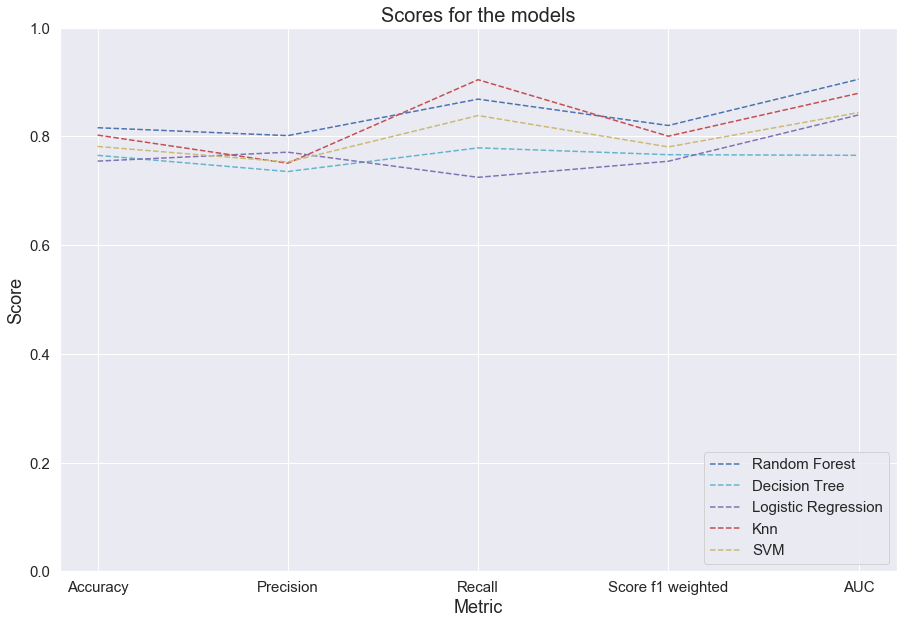

In [230]:
value_x = ['Accuracy', 'Precision', 'Recall', 'Score f1 weighted', "AUC"]

Y_rf = [accuracy_rf, precision_rf, recall_rf, f1_weighted_rf, auc_rf]
Y_tree = [accuracy_tree, precision_tree, recall_tree, f1_weighted_tree, auc_tree]
Y_log = [accuracy_log, precision_log, recall_log, f1_weighted_log, auc_log]
Y_knn = [accuracy_knn, precision_knn, recall_knn, f1_weighted_knn, auc_knn]
Y_svm = [accuracy_svm, precision_svm, recall_svm, f1_weighted_svm, auc_svm]

plt.figure(1, figsize=(15, 10))

plt.plot(value_x, Y_rf, 'b--', label='Random Forest')
plt.plot(value_x, Y_tree, "c--", label="Decision Tree")
plt.plot(value_x, Y_log, "m--", label="Logistic Regression")
plt.plot(value_x, Y_knn, 'r--', label='Knn')
plt.plot(value_x, Y_svm, 'y--', label='SVM')

plt.title("Scores for the models", fontsize=20)
plt.ylim(0, 1)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Score")
plt.xlabel("Metric")
plt.legend(fontsize=15, loc='lower right')
plt.show()

No one model appears to be completely superior to the others in terms of all the metrics represented. However, Random Forest seems to have the best and above all more stable results from all the other models.

In [224]:
def printed_confusion_matrix(model, model_name):
    '''
    Create a function to print the confusion matrix, with the name of categories, the number and the pourcentage 
    '''
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    group_names = ['True Neg', "False Pos", "False Neg", 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_pourcentage = ["{0:.2%}".format(value) for value in cm_normalized.flatten()]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_pourcentage)]
    labels = np.asarray(labels).reshape(2, 2)

    sns.heatmap(cm_normalized, annot=labels, fmt='', cmap=plt.cm.Blues, annot_kws={'fontsize':15}, vmin=0, vmax=1, square=True)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15, rotation=0)
    plt.title("Confusion Matrix for " + model_name, fontsize=20)
    return y_pred

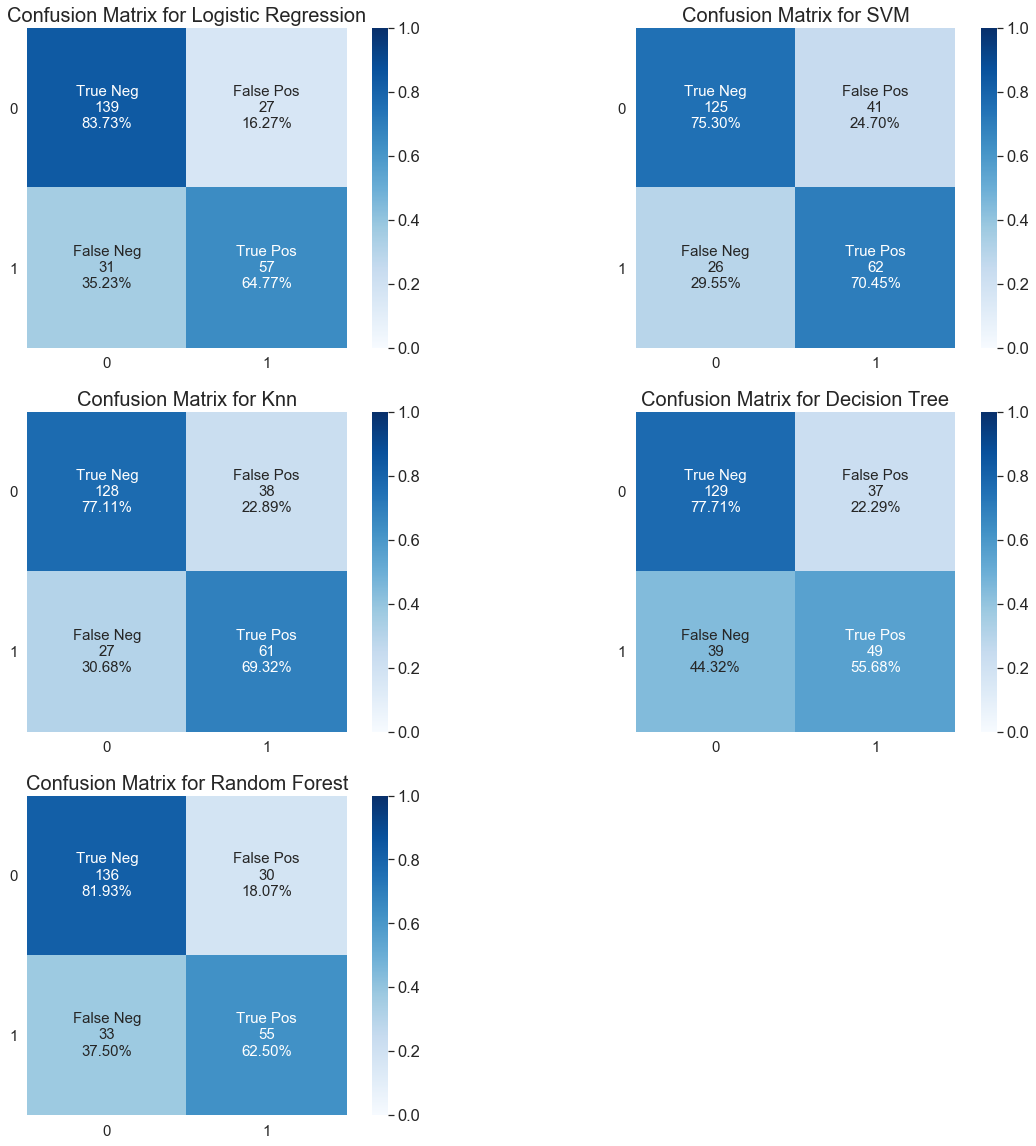

In [232]:
models = [best_model_log, best_model_svm, best_model_knn, best_model_tree, best_model_rf]
models_name = ['Logistic Regression', "SVM", "Knn", "Decision Tree", "Random Forest"]

for i in range(len(models)):
    plt.figure(1, figsize=(20, 20))
    plt.subplot(3, 2, i + 1)
    y_pred = printed_confusion_matrix(models[i], models_name[i])

We can see that it is very good at predicting people who will not get diabetes. However, it is more complicated for him to know about those who will have it. This can surely be explained by the fact that the starting dataset was unbalanced and thus, even if we wanted to do oversampling, this still influences the learning of the model.

### Interpretability

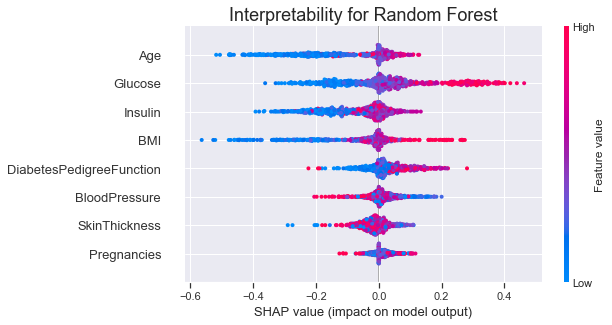

In [302]:
# Find the interpretability of the model thanks to the shap library
f = lambda x: best_model_rf.predict_proba(x)[:,1]
med = X_train_df.median().values.reshape((1,X_train_df.shape[1]))
explainer = shap.KernelExplainer(f, med)
shap_values = explainer.shap_values(X_train_df.iloc[:,:], nsamples=668)
plt.title("Interpretability for Random Forest")
shap.summary_plot(shap_values, X_train_df.iloc[:,:])
plt.show()

For instance, this means that the more glucose you have, the greater the chance you have of getting diabetes.